In [17]:
import numpy as np
import pandas as pd #For read data 
import emcee  #For maximization of likelihood
import tqdm   #for progress bar 
import scipy.integrate as si #For numerical integration
import matplotlib.pyplot as plt  #For plots
from sklearn.linear_model import LinearRegression  #For linear regression
from sklearn.metrics import r2_score  #For R² of linear regression
from getdist import plots, MCSamples #For corner plots

In [ ]:
#Let's load the data of DES  

data = pd.read_csv('path/DES-SN5YR_HD+MetaData.csv', sep=',', header = 0)
display(data)

,CID,CIDint,IDSURVEY,TYPE,zHEL,zHELERR,zCMB,zCMBERR,zHD,zHDERR,...,PROB_SNIRFV19,PROB_SNNDESCC,PROB_SNNJ17,PROB_SNNV19,MU,MUERR_FINAL,PROBCC_BEAMS,biasCor_mu,biasCor_muCOVSCALE,biasCor_muCOVADD
0,1246275,1246275,10,0,0.24651,0.00100,0.24605,0.00100,0.24605,0.00160,...,0.8486,1.0000,0.9999,1.0000,40.5938,0.0968,0.0,0.0341,1.000,0.0050
1,1246281,1246281,10,0,0.33600,0.00100,0.33549,0.00100,0.33549,0.00167,...,1.0000,1.0000,0.9999,1.0000,41.2263,0.1360,0.0,-0.0492,1.000,0.0136
2,1246314,1246314,10,0,0.38388,0.00100,0.38337,0.00100,0.38337,0.00171,...,0.7823,0.9993,0.9970,0.9998,41.6383,0.2332,0.0,0.0502,1.000,0.0348
3,1246527,1246527,10,0,0.32184,0.00100,0.32078,0.00100,0.32078,0.00166,...,1.0000,0.9997,0.9998,1.0000,41.1991,0.1503,0.0,-0.0511,1.000,0.0173
4,1246529,1246529,10,0,0.49797,0.00100,0.49677,0.00100,0.49677,0.00180,...,0.9407,0.9996,0.9993,1.0000,42.1471,0.1618,0.0,-0.0485,1.000,0.0095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1824,SN2017cpu,106,150,1,0.05440,0.00001,0.05529,0.00001,0.05502,0.00088,...,-9.0000,-9.0000,-9.0000,-9.0000,36.8308,0.0872,0.0,-0.0396,0.878,0.0000
1825,SN2017hn,123,150,1,0.02385,0.00001,0.02492,0.00001,0.02557,0.00085,...,-9.0000,-9.0000,-9.0000,-9.0000,35.2067,0.1183,0.0,-0.0550,1.000,0.0029
1826,SN2017mf,158,150,1,0.02561,0.00001,0.02618,0.00001,0.02598,0.00086,...,-9.0000,-9.0000,-9.0000,-9.0000,35.3916,0.1237,0.0,-0.0707,1.000,0.0050
1827,SN2017ms,176,150,1,0.02448,0.00001,0.02538,0.00001,0.02591,0.00086,...,-9.0000,-9.0000,-9.0000,-9.0000,35.3421,0.1160,0.0,-0.0007,1.000,0.0014


Slope (a): 5.521
Intercept (b): 43.968
R²: 0.9840


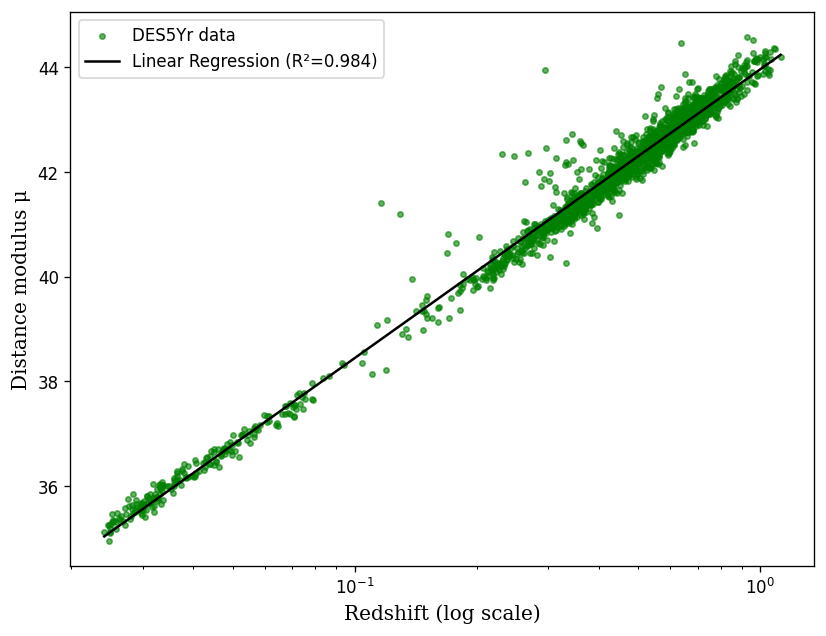

In [3]:
z = data['zCMB']
mu = data['MU']
mu_err = data['MUERR_FINAL']
mb = data['mB']
mb_err = data['mBERR']
x1 = data['x1']
c = data['c']

# Convert z and mu to numpy arrays
x = np.log10(z.values).reshape(-1, 1)  # log(z) as input feature for the model
y = mu.values 

# Fit linear regression model
model = LinearRegression()
model.fit(x, y)

a = model.coef_[0]
b = model.intercept_
print(f"Slope (a): {a:.3f}")
print(f"Intercept (b): {b:.3f}")

# Generate fitted curve points
z_fit = np.linspace(min(z), max(z), 200)
x_fit = np.log10(z_fit).reshape(-1, 1)
y_fit = model.predict(x_fit)

# Calculate R² correctly using the original data
y_pred_train = model.predict(x)  # prediction on training data points
r2 = r2_score(y, y_pred_train)
print(f"R²: {r2:.4f}")

# Plotting
plt.figure(figsize=(8, 6), dpi=120)
plt.scatter(z, mu, color='green', s=10, alpha=0.6, label='DES5Yr data')
plt.plot(z_fit, y_fit, color='black', label=f'Linear Regression (R²={r2:.3f})')
plt.xscale('log')
plt.xlabel('Redshift (log scale)', fontdict={'family': 'serif', 'size': 12, 'weight': 'normal'})
plt.ylabel('Distance modulus μ', fontdict={'family': 'serif', 'size': 12, 'weight': 'normal'})
plt.legend()
plt.show()


In [ ]:
#Let's load the systematic erros   

data_sys_errors = np.loadtxt('path/covsys_000.txt', skiprows=1) #load txt and skip the first term 

with open('path/covsys_000.txt') as f: n = int(f.readline().strip())  #read the first term of txt and save as 'n'

sys_errors = data_sys_errors.reshape(n, n) #construct the matrix of n x n for sys errors 

#print(sys_errors)



#To make the covariance matrix we have to sum the systematic errors with statistical errors



# First we have to take a column of statistical errors in data

est_errors = data['MUERR_FINAL'].to_numpy() #Transform in array

est_errors = np.diag(est_errors**2) #Transform the array in diagonal matrix

#print(est_errors)


#The covariance matrix

Cij = sys_errors + est_errors


#Inverse with linear algebra inverse of numpy

InvCovTot = np.linalg.inv(Cij)


print(InvCovTot)


[[ 1.06164079e+02 -9.33568024e-02 -7.38024264e-03 ...  5.68856689e-02
  -3.92702031e-01  6.20350830e-02]
 [-9.33568024e-02  5.37723037e+01  1.78031353e-02 ... -2.82727424e-01
  -1.65590734e-02  6.14428579e-02]
 [-7.38024264e-03  1.78031353e-02  1.83215211e+01 ...  6.65541833e-02
   2.06268901e-02 -3.20157406e-03]
 ...
 [ 5.68856689e-02 -2.82727424e-01  6.65541833e-02 ...  6.46214591e+01
   1.09072621e-01  5.28621371e-02]
 [-3.92702031e-01 -1.65590734e-02  2.06268901e-02 ...  1.09072621e-01
   7.30332411e+01  6.17409561e-02]
 [ 6.20350830e-02  6.14428579e-02 -3.20157406e-03 ...  5.28621371e-02
   6.17409561e-02  1.20437952e+01]]


In [5]:
zcmb = data['zCMB']
mu = data['MU']

velc = 299792.4580  # speed of light in [km/s] 

# Hubble parameter of the cosmological model
def H(z, om, H0):
    Ez = np.sqrt(om * (1.0 + z)**3 + (1.0 - om))
    return H0 * Ez

# Luminosity distance 
def dL(z, om, H0):

    def integrand(zz, om, H0):
        return 1.0 / H(zz, om, H0)
    
    integral = si.quad(integrand, 0, z, args=(om, H0))[0]
    return (1.0 + z) * velc * integral

# Distance modulus 
def muth(z, om, H0):
    return 5 * np.log10(dL(z, om, H0)) + 25

# Log-likelihood including color and stretch coefficients
def log_likelihood_sn_ab(om, H0, α, β, M):

    def mbth(z, om, H0, α, β, M, x11, cc):
        return muth(z, om, H0) + M - α * x11 + β * cc

    chi2 = sum(((mb[i] - mbth(zcmb[i], om, H0, α, β, M, x1[i], c[i])) / mb_err[i])**2 
               for i in range(len(zcmb)))

    return -0.5 * chi2

# Log-likelihood using only the distance modulus
def log_likelihood_sn(om, H0):
    mu_vec = np.vectorize(lambda z: muth(z, om, H0))(zcmb)
    diff = mu - mu_vec
    chi2 = np.dot(diff, InvCovTot @ diff)
    return -0.5 * chi2


In [6]:
# Priors
def log_prior(om, H0):
    if not 0.1 < om < 0.5:
        return -np.inf
    if not 60.0 < H0 < 80.0:
        return -np.inf
#    if not -1.0 < α < 1.0:
#        return -np.inf
#    if not 0.0 < β < 5.0:
#        return -np.inf
#    if not -25.0 < M < -10.0:
#        return -np.inf
    
    return 0

# Total log-likelihood (posterior)
def log_probability(listparams):

    # om, H0, α, β, M = listparams
    om, H0 = listparams

    lp = log_prior(om, H0) 
    if not np.isfinite(lp):  # if lp is not finite, reject parameters
        return -np.inf       
    lpprior = lp            

    log_probability_tot = log_likelihood_sn(om, H0)

    return log_probability_tot

# Initial guess for our parameters
# om_ini, H0_ini, α_ini, β_ini, M_ini = 0.3, 70.0, 0.0, 1.0, -19.0
om_ini, H0_ini = 0.3, 70.0

# List of initial parameter values
# param_ini = [om_ini, H0_ini, α_ini, β_ini, M_ini]
param_ini = [om_ini, H0_ini]


In [7]:
dim = len(param_ini) 

pos = param_ini + 1e-4 * np.random.randn(10,dim)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

totalsteps = 100000
coords = pos
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(totalsteps)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(coords, iterations=totalsteps, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau



  4%|▍         | 4500/100000 [55:13<19:31:49,  1.36it/s]


Text(0.5, 0, 'step number')

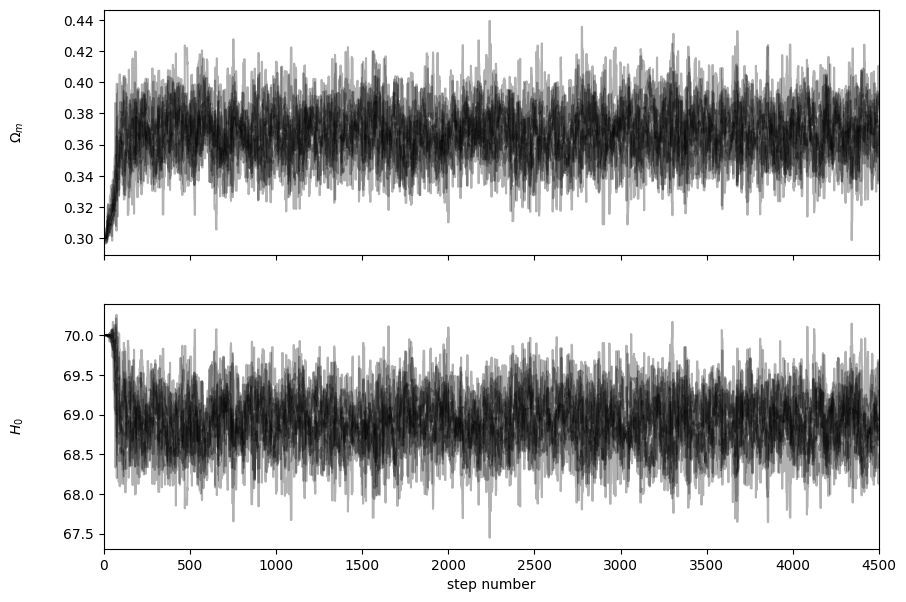

In [16]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

#labels = [r"\Omega_m", "H_0", "α", "β", "M"]
labels = [r"$\Omega_m$", r"$H_0$"]

ndim = len(labels)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [9]:
import arviz as az

# This code belongs to the MCMC convergence diagnostic step after sampling with emcee.

# Convert the emcee sampler object into an ArviZ InferenceData object.
# ArviZ provides tools for analyzing and visualizing Bayesian inference results.
data = az.from_emcee(sampler)

# Compute and print the R-hat statistic (Gelman-Rubin diagnostic) for each parameter.

# R-hat measures the convergence of MCMC chains:
# - Values close to 1 indicate good convergence (chains mixing well).
# - Values significantly greater than 1 indicate poor convergence (chains may not have mixed).
print(az.rhat(data))

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    var_0    float64 8B 1.006
    var_1    float64 8B 1.005


In [10]:
tau = sampler.get_autocorr_time()
ndim = dim

burnin = int(3 * np.max(tau))  # discarding 3 × tau from the initial steps
thin = int(0.5 * np.min(tau))  # thinning to about half of tau

samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)

print("Autocorrelation time: {0}".format(tau))
print("Burn-in: {0}".format(burnin))
print("Thin: {0}".format(thin))
print("Flat chain shape: {0}".format(samples.shape))
print("Flat log prob shape: {0}".format(log_prob_samples.shape))


Autocorrelation time: [40.81558978 43.23059867]
Burn-in: 129
Thin: 20
Flat chain shape: (2180, 2)
Flat log prob shape: (2180,)


In [11]:
np.savetxt("MCMC_param_FLCDM.txt", np.array(samples))
np.savetxt("MCMC_log_prob_FLCDM.txt", np.array(log_prob_samples))

In [12]:
# Reading MCMC output files - Flat-LCDM model
MCMC_full = pd.read_fwf("MCMC_param_FLCDM.txt", sep=' ', names=['om', 'H0'])
MCMC_log_prob_full = pd.read_fwf("MCMC_log_prob_FLCDM.txt", sep=' ', names=['log_prob'])


In [13]:
from IPython.display import display, Math

sample = np.array(MCMC_full)
labels = [r"\Omega_m", "H0"]
ndim = sample.shape[1]

print("Mean and statistical confidence interval:")
alpha = (100 - 68.3) / 2  # 1 sigma confidence level
# alpha = (100 - 95.4) / 2  # 2 sigma confidence level
# alpha = (100 - 99.7) / 2  # 3 sigma confidence level

MeanParam = []
for i in range(ndim):
    mcmc1s = np.percentile(sample[:, i], [alpha, 50, 100 - alpha])  # percentiles for 1-sigma interval (68.3%)
    q1s = np.diff(mcmc1s)
    
    txt = r"\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc1s[1], q1s[0], q1s[1], labels[i])
    
    MeanParam.append(np.around(mcmc1s[1], 3))
    display(Math(txt))

print("Best fit and minimum chi-square:")

# If MCMC_log_prob_full is not a DataFrame, convert it
if not isinstance(MCMC_log_prob_full, pd.DataFrame):
    MCMC_log_prob_full = pd.DataFrame(MCMC_log_prob_full, columns=["log_prob"])

list_chi2_df = -2 * MCMC_log_prob_full  # chi-squared values

indxmin = list_chi2_df["log_prob"].idxmin()  # index of minimum chi²
display(MCMC_full.loc[indxmin])  # parameters corresponding to minimum chi²
print("chi2min = ", np.around(list_chi2_df.loc[indxmin, 'log_prob'], 3))


Mean and statistical confidence interval:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Best fit and minimum chi-square:


om     0.367776
H0    68.897583
Name: 665, dtype: float64

chi2min =  1660.15


Removed no burn in


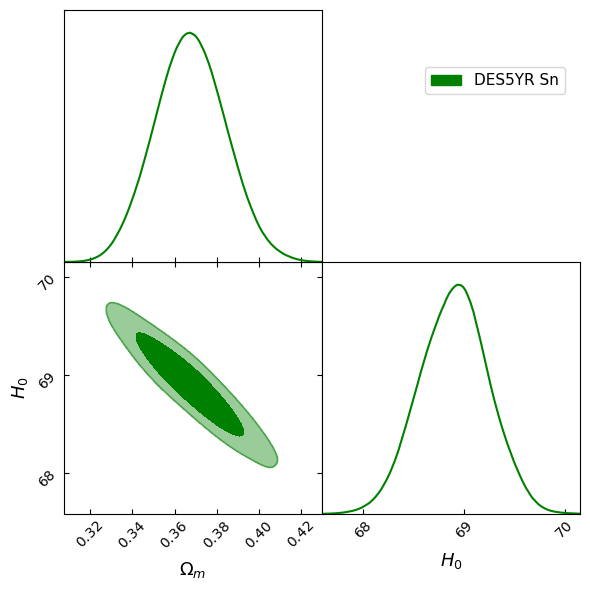

In [ ]:
#names = ['x0','x1','x2','x3','x4']
#labels = [r"\Omega_m", "H_0", "α", "β", "M"]

names = ['x0','x1']
labels = [r"\Omega_m", "H_0"]

# Creating MCSamples object with parameter names, labels and ranges
sample = MCSamples(
    samples=np.array(MCMC_full), 
    names=names, 
    labels=labels,
    label='Full',
    #ranges={'x0':[0.20,0.5],'x1':[60,80], 'x2':[0.0,5.0], 'x3':[0.0,1.0], 'x4':[-30.0,-10.0]}
    ranges={'x0':[0.20,0.5],'x1':[60,80]}
)


## Plot settings #######
g = plots.get_subplot_plotter(width_inch=6)
g.settings.title_limit_fontsize = 12
g.settings.figure_legend_frame = True
# g.settings.alpha_filled_add = 0.7
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_y_rotation = 45
g.settings.axis_tick_max_labels = 20




# Plot the triangle plot (corner plot)
g.triangle_plot(
    [sample], ['x0', 'x1'], 
    shaded=False,
    filled=[True], 
    line_args=[{'lw':1.5, 'color': "Green"}],
    contour_lws=[1.5], 
    contour_ls=['-'],
    contour_colors=["Green"], 
    alphas=[1.0],  
    legend_labels=["DES5YR Sn"], 
    legend_loc=[0.72, 0.84],  # legend position
    # title_limit=1,  # first title limit (for 1D plots) is 68% by default
)
